In [1]:
# set working directory
import sys
import os
from pathlib import Path
sys.path.insert(0, Path(os.getcwd()).parent)
os.chdir(sys.path[0])

# Unsupervised ML from Seismic Attributes

In [2]:
# Import libraries
from cuml.manifold import UMAP
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import rasterio
import geopandas as gpd
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from sknetwork.clustering import Louvain

In [3]:
# Import functions from the functions script
from functions.functions import pre_process
from functions.functions import run_umap
from functions.functions import get_classes
from functions.functions import preprocess_pipeline
from functions.functions import Umap_vis
from functions.functions import clusters
from functions.functions import re_order_clusters
from functions.functions import Umap_vis_alternative

## Pre process the Dataframes

In [4]:
# Define the path to the dataframes of extracted features
directory_path = 'data/features'

# Import the gas field and dry structure polygons
gas = gpd.read_file('data/boundaries/Gas_json.geojson')
nogas = gpd.read_file('data/boundaries/No_Gas_json_3857.geojson')

In [ ]:
# Run the preprocessing and dimension reduction
proc_dfs, meta_dfs, umap_obj = preprocess_pipeline(directory_path, 0.95, 100, 0.001, gas, nogas)

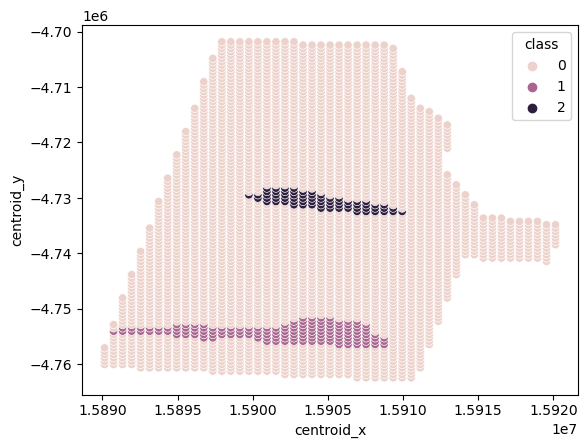

In [6]:
# Check the test and training sets
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data=meta_dfs['feats_clr'], x='centroid_x', y='centroid_y', hue='class')

# Show the plot
plt.show()

## Visualise the UMAP Embeddings

In [7]:
for key in proc_dfs:
    print(key)

feats_clr
feats_greyscale
feats_hillshade


In [16]:
# Visualise and compare the UMAP of each feature set
clr_list = ['#808080', '#800080', '#FF0000']
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=("Greyscale", "Coloured RGB", "Hillshade RGB")  # This will create titles above each subplot
)

plot1 = Umap_vis(proc_dfs, meta_dfs, 'feats_greyscale', clr_list)
plot2 = Umap_vis(proc_dfs, meta_dfs, 'feats_clr', clr_list)
plot3 = Umap_vis(proc_dfs, meta_dfs, 'feats_hillshade', clr_list)

# Assuming plot1, plot2, plot3 are figure objects
for i, plot in enumerate([plot1, plot2, plot3], start=1):
    for trace in plot.data:
        fig.add_trace(
            go.Scatter3d(
                x=trace.x, y=trace.y, z=trace.z,
                mode=trace.mode, marker=trace.marker
            ),
            row=1, col=i
        )
        
fig.update_layout(height=600, width=1800, title_text="Comparison of UMAP visualisations")

fig.show()

## Cluster the UMAP Embeddings

In [18]:
# Run clustering for each of the feature sets and re-order cluster labels for visualisation purposes
labelled = {}
for key in umap_obj:
    # Run the Louvain clustering
    df = clusters(umap_obj, key, proc_dfs)
    # Re-order the clusters based on UMAP location
    df1 = re_order_clusters(df)
    # append the dataframe to a list
    labelled[key] = df1

[0 1 2 3 4 5 6 7 8 9]
[ 0  1  2  3  4  5  6  7  8  9 10]
[0 1 2 3 4 5 6 7 8 9]


In [25]:
# Visualise and compare the UMAP of each feature set
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]],
    subplot_titles=("Greyscale", "Coloured RGB", "Hillshade RGB")  # This will create titles above each subplot
)

plot1 = Umap_vis_alternative(labelled['feats_greyscale'], 'feats_greyscale')
plot2 = Umap_vis_alternative(labelled['feats_clr'], 'feats_clr')
plot3 = Umap_vis_alternative(labelled['feats_hillshade'], 'feats_hillshade')

# Assuming plot1, plot2, plot3 are figure objects
for i, plot in enumerate([plot1, plot2, plot3], start=1):
    for trace in plot.data:
        fig.add_trace(
            go.Scatter3d(
                x=trace.x, y=trace.y, z=trace.z,
                mode=trace.mode, marker=trace.marker
            ),
            row=1, col=i
        )
        
fig.update_layout(height=600, width=1800, title_text="Comparison of UMAP visualisations")

fig.show()

## Visualise the clusters in plan view

In [26]:
#add the geometry column to the correct dataframe
for key in labelled:
    labelled[key]['geometry'] = meta_dfs[key]['geometry']

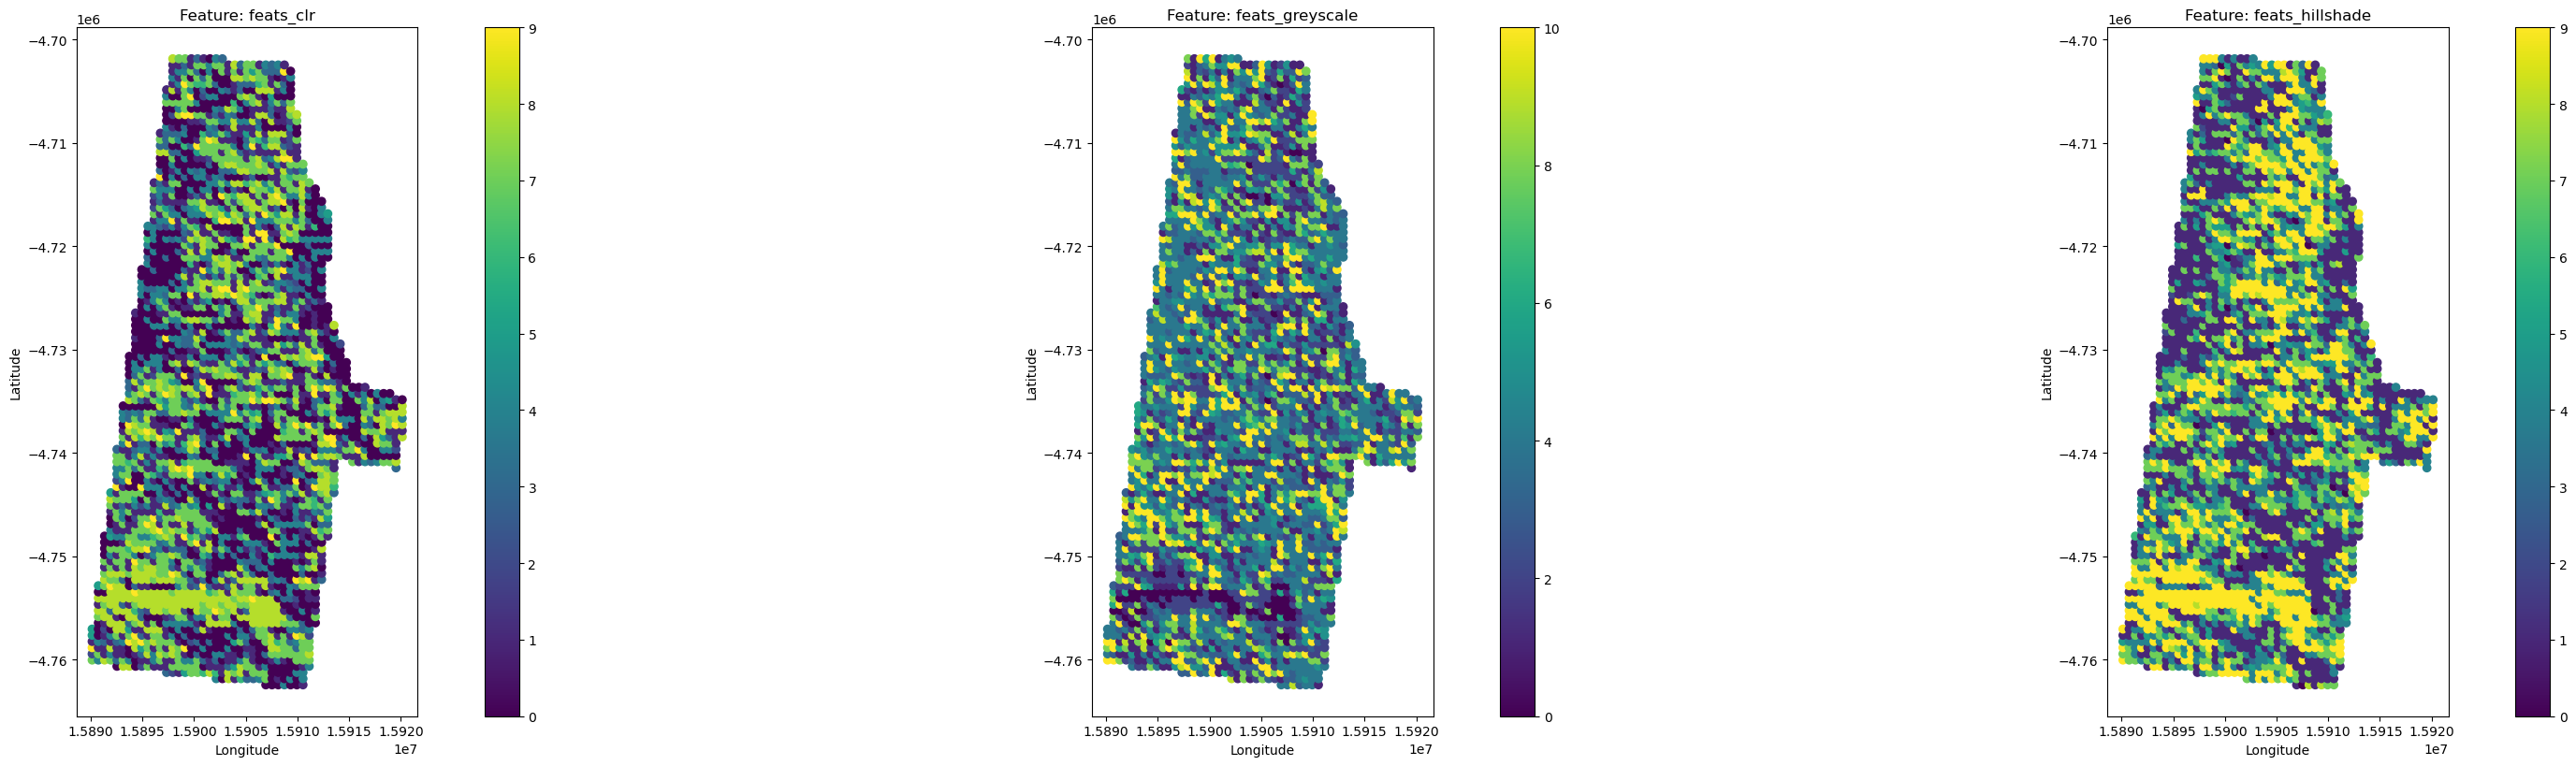

In [34]:
# Number of plots
n_plots = len(labelled)
# Determine the grid size (you might want to adjust this depending on your dataset)
cols = 3  # for example, 3 columns
rows = -(-n_plots // cols)  # ceiling division to get the number of rows

# Adjust the overall size of the figure (width, height)
fig, axes = plt.subplots(rows, cols, figsize=(cols * 12, rows * 8))  # Increased size
axes = axes.flatten()

for i, key in enumerate(labelled):
    gdf = gpd.GeoDataFrame(labelled[key], geometry='geometry')
    # Plotting in the i-th subplot
    gdf.plot(ax=axes[i], column='reordered_cluster', legend=True)

    # Customizations
    axes[i].set_title(f'Feature: {key}')
    axes[i].set_xlabel('Longitude')
    axes[i].set_ylabel('Latitude')

# If there are any remaining empty subplots, turn them off
for j in range(i + 1, rows * cols):
    axes[j].axis('off')

plt.tight_layout(pad=0.0)  # Adjust the padding between plots
plt.show()